## Final Project Submission

Please fill out:
* Student name: John Karanja, David Munyiri, Catherine Gachiri, Jeremiah Bii
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Fidelis Wanalwenge
* Blog post URL:


# 🎬 Movie Studio Investment Analysis

## Project Overview
This notebook explores movie performance data to help our company decide **what types of films to create**.  
We will use exploratory data analysis and statistical modeling to answer business questions about ROI.

**Key Data Sources:**
- **The Numbers** (`tn.movie_budgets.csv.gz`) → Budgets & grosses (used for ROI).
- **IMDB** (`im.db`) → Movie metadata (genres, runtime, year).
- **Box Office Mojo** (`bom.movie_gross.csv.gz`) → Additional grosses (optional).

**Goal:** Build a dataset that combines **financial data** (budgets & grosses) with **metadata** (genres, runtime, release timing) for statistical analysis.

## Business Understanding
Our stakeholders (head of the new movie studio) want to know:

1. **Genres vs ROI** – Which genres yield the best returns?  
2. **Release Quarter vs ROI** – Does timing affect financial success?  
3. **Budget vs ROI %** – Are bigger budgets more (or less) profitable?  
4. **Runtime vs ROI** – Does movie length impact profitability?

We will prepare a clean dataset to test these hypotheses.

## Step 1: Load and Inspect Data

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re
from pathlib import Path

# Define paths
data_dir = Path('zippedData')
bom_path = data_dir/'bom.movie_gross.csv.gz'
tn_path = data_dir/'tn.movie_budgets.csv.gz'
imdb_path = Path('zippedData/im.db')

# Load Box Office Mojo
bom = pd.read_csv(bom_path)
print("Box Office Mojo sample:")
display(bom.head())
display(bom.shape)

# Load The Numbers (budgets)
tn = pd.read_csv(tn_path)
print("The Numbers sample:")
display(tn.head())
display(tn.shape)

# Inspect IMDB tables
con = sqlite3.connect(imdb_path)
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", con)
print("IMDB Tables:")
display(tables)


Box Office Mojo sample:


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


(3387, 5)

The Numbers sample:


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


(5782, 6)

IMDB Tables:


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## Step 2: Clean `The Numbers` Dataset

In [2]:
tn_clean = tn.copy()

# Convert currency columns to numeric
currency_cols = ["production_budget", "domestic_gross", "worldwide_gross"]
for col in currency_cols:
    tn_clean[col] = (tn_clean[col]
                     .replace('[\$,]', '', regex=True)
                     .astype(float))

# Parse release date
tn_clean["release_date"] = pd.to_datetime(tn_clean["release_date"], errors="coerce")
tn_clean["year"] = tn_clean["release_date"].dt.year
tn_clean["quarter"] = tn_clean["release_date"].dt.quarter

# Compute ROI
tn_clean["ROI"] = (tn_clean["worldwide_gross"] - tn_clean["production_budget"]) / tn_clean["production_budget"]

display(tn_clean.head())
display(tn_clean.shape)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,quarter,ROI
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,4,5.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,2,1.546673
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,2,-0.572108
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,2,3.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,4,3.153696


(5782, 9)

## Step 3: Extract Metadata from IMDB

In [3]:
con = sqlite3.connect(imdb_path)
imdb = pd.read_sql("""
    SELECT movie_id, primary_title, start_year, runtime_minutes, genres
    FROM movie_basics
    WHERE start_year BETWEEN 1980 AND 2025
      AND primary_title IS NOT NULL
""", con)
con.close()

imdb.head()


,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"


## Step 4: Normalize Titles and Join Datasets

In [4]:
# Title normalization function
def normalize_title(title: str) -> str:
    if pd.isna(title):
        return np.nan
    title = title.lower().strip()
    title = re.sub(r"\([^)]*\)", "", title)  # remove parentheticals
    title = re.sub(r"[^a-z0-9 ]", "", title)   # drop punctuation
    title = re.sub(r"\s+", " ", title).strip()
    return title

tn_clean["title_norm"] = tn_clean["movie"].map(normalize_title)
imdb["title_norm"] = imdb["primary_title"].map(normalize_title)

# Bring in ratings to get numvotes
con = sqlite3.connect(imdb_path)
ratings = pd.read_sql("SELECT movie_id, averagerating, numvotes FROM movie_ratings;", con)
con.close()

imdb_full = (imdb.merge(ratings, on='movie_id', how='left')
                 .assign(numvotes=lambda d: d['numvotes'].fillna(0),
                         runtime_minutes=lambda d: d['runtime_minutes'].fillna(-1)))

# Sort by best proxy for canonical record, then keep first per key
imdb_dedup = (imdb_full.sort_values(['title_norm','start_year','numvotes','runtime_minutes'],
                                    ascending=[True, True, False, False])
                        .drop_duplicates(['title_norm','start_year'], keep='first')
                        .drop(columns=['averagerating','numvotes']))  # keep if you need them

# Re-join with deduped IMDB
movies_dedup = tn_clean.merge(
    imdb_dedup, left_on=['title_norm','year'], right_on=['title_norm','start_year'], how='left'
)
len(movies_dedup) - len(tn_clean)   # ← should now be ~0 (or much smaller)

display(movies_dedup.head())
display(movies_dedup.shape)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,quarter,ROI,title_norm,movie_id,primary_title,start_year,runtime_minutes,genres
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,4,5.532577,avatar,NaN,NaN,NaN,NaN,NaN
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,2,1.546673,pirates of the caribbean on stranger tides,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"Action,Adventure,Fantasy"
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,2,-0.572108,dark phoenix,tt6565702,Dark Phoenix,2019.0,113.0,"Action,Adventure,Sci-Fi"
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,2,3.243841,avengers age of ultron,tt2395427,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi"
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,4,3.153696,star wars ep viii the last jedi,NaN,NaN,NaN,NaN,NaN


(5782, 15)

## Step 5: Create Final Analysis Dataset

In [5]:
analysis_df = movies_dedup[[
    "movie", "release_date", "year", "quarter",
    "production_budget", "worldwide_gross", "ROI",
    "runtime_minutes", "genres"
]].copy()

display(analysis_df.head(10))
analysis_df.shape

,movie,release_date,year,quarter,production_budget,worldwide_gross,ROI,runtime_minutes,genres
0,Avatar,2009-12-18,2009,4,425000000.0,2.776345e+09,5.532577,NaN,NaN
1,Pirates of the Caribbean: On Stranger Tides,2011-05-20,2011,2,410600000.0,1.045664e+09,1.546673,136.0,"Action,Adventure,Fantasy"
2,Dark Phoenix,2019-06-07,2019,2,350000000.0,1.497624e+08,-0.572108,113.0,"Action,Adventure,Sci-Fi"
3,Avengers: Age of Ultron,2015-05-01,2015,2,330600000.0,1.403014e+09,3.243841,141.0,"Action,Adventure,Sci-Fi"
4,Star Wars Ep. VIII: The Last Jedi,2017-12-15,2017,4,317000000.0,1.316722e+09,3.153696,NaN,NaN
5,Star Wars Ep. VII: The Force Awakens,2015-12-18,2015,4,306000000.0,2.053311e+09,5.710167,NaN,NaN
6,Avengers: Infinity War,2018-04-27,2018,2,300000000.0,2.048134e+09,5.827114,149.0,"Action,Adventure,Sci-Fi"
7,Pirates of the Caribbean: At Worldâs End,2007-05-24,2007,2,300000000.0,9.634204e+08,2.211401,NaN,NaN
8,Justice League,2017-11-17,2017,4,300000000.0,6.559452e+08,1.186484,120.0,"Action,Adventure,Fantasy"
9,Spectre,2015-11-06,2015,4,300000000.0,8.796209e+08,1.932070,148.0,"Action,Adventure,Thriller"


(5782, 9)

In [6]:
# Drop rows without ROI
df = analysis_df.dropna(subset=["ROI"]).copy()

# Extract primary genre (first listed)
#df["primary_genre"] = df["genres"].dropna().apply(lambda x: x.split(",")[0] if isinstance(x, str) else np.nan)

# 1) Explode genres so a movie appears once per genre
df_multi = df.dropna(subset=["genres"]).copy()
df_multi["genre"] = df_multi["genres"].str.split(",")
df_multi = df_multi.explode("genre")
df_multi["genre"] = df_multi["genre"].str.strip()

# 2) Cluster id: all repeated rows from same movie share this
# (use an actual unique id if you have it; title+year is a good fallback)
df_multi["cluster_id"] = (
    df_multi["movie"].str.lower().str.strip() + "_" + df_multi["year"].astype(str)
)

# (optional) keep genres with enough data
counts = df_multi["genre"].value_counts()
keep = counts[counts >= 30].index
sub = df_multi[df_multi["genre"].isin(keep)].copy()

# Hypothesis-specific datasets
df_genre   = df_multi.dropna(subset=["genre"])
df_quarter = df.dropna(subset=["quarter"])
df_budget  = df[df["production_budget"] > 0].copy()
df_runtime = df.dropna(subset=["runtime_minutes"])

print("Base dataset:", df.shape)
print("Genre dataset:", df_genre.shape)
print("Quarter dataset:", df_quarter.shape)
print("Budget dataset:", df_budget.shape)
print("Runtime dataset:", df_runtime.shape)

Base dataset: (5782, 9)
Genre dataset: (4030, 11)
Quarter dataset: (5782, 9)
Budget dataset: (5782, 9)
Runtime dataset: (1582, 9)


In [7]:
analysis_df.to_excel("analysis_data.xlsx", index=False)

# Statistical analysis to tackle key business considerations

# Genre Analysis: Which Film Genres Yield the Best ROI?

## Hypothesis
**H0 (Null):** There is no significant difference in ROI between different movie genres.  
**H1 (Alternative):** Certain genres consistently outperform others in terms of ROI, making them more attractive investment targets.

## Key Assumptions
- ROI is calculated as: (Worldwide Gross - Production Budget) / Production Budget
- Movies with multiple genres contribute to each genre's performance metrics (accepted limitation)
- Genre classification from IMDB is accurate and consistent
- Sample includes movies from major studios with reliable financial data
- Market conditions and audience preferences remain relatively stable within genre categories
- Multi-genre movies may create correlated observations but provide comprehensive genre representation

## Methodology
1. Extract and clean genre data from IMDB database
2. Handle multi-genre movies by exploding genres (each movie-genre combination treated as separate observation)
3. Calculate descriptive statistics for ROI by genre, including mean and median analysis
4. **Perform one-way ANOVA test** to determine if mean ROI differs significantly across genres
5. Compare mean vs median to assess distribution skewness and outlier effects
6. Visualize results to identify patterns, outliers, and risk profiles

### Why ANOVA?
**ANOVA (Analysis of Variance)** is the appropriate statistical test because:
- We're comparing means across **multiple groups** (genres) simultaneously
- Our dependent variable (ROI) is **continuous**
- We want to test if **any** genres differ significantly from others
- Alternative tests are not suitable:
  - *t-tests*: Only compare 2 groups at a time
  - *Chi-square*: For categorical dependent variables
  - *Regression*: We're not predicting ROI from genre as a continuous variable
  - *Z-test*: Requires known population parameters

### Multi-Genre Limitation
We acknowledge that movies with multiple genres contribute to each genre's statistics, potentially creating correlated observations. However, this approach provides:
- Complete representation of genre diversity in cinema
- Realistic business perspective (movies often span multiple genres)
- Maintains sample sizes necessary for statistical analysis

In [23]:
# STATISTICAL ANALYSIS 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Aggregate per-genre stats
genre_stats = (
    df_genre.groupby('genre')
    .agg(ROI_count=('ROI','size'),
         ROI_mean=('ROI','mean'),
         ROI_median=('ROI','median'),
         ROI_std=('ROI','std'))
    .sort_values('ROI_mean', ascending=False)
)

# Add derived metrics
genre_stats['mean_median_ratio'] = (
    genre_stats['ROI_mean'] / genre_stats['ROI_median'].replace(0, np.nan)
).replace([np.inf, -np.inf], np.nan)

# Create risk categories
def categorize_risk(std_dev):
    if std_dev > 3.0:
        return "High Risk"
    elif std_dev > 1.5:
        return "Medium Risk" 
    else:
        return "Low Risk"

genre_stats['risk_category'] = genre_stats['ROI_std'].apply(categorize_risk)

# Create distribution type
def categorize_distribution(ratio):
    if pd.isna(ratio):
        return "Unknown"
    elif ratio > 2.0:
        return "Outlier-driven"
    elif ratio > 1.5:
        return "Moderately skewed"
    else:
        return "Normal-like"

genre_stats['distribution_type'] = genre_stats['mean_median_ratio'].apply(categorize_distribution)

# Filtered stats (you can adjust ROI_count threshold as per your narrative)
genre_stats_filtered = genre_stats.query('ROI_count >= 20').copy()

# Top 6 genres for boxplot
top_genres = genre_stats_filtered.head(6).index.tolist()

# ANOVA test across ROI by genre
groups = [df_genre.loc[df_genre['genre']==g, 'ROI'].dropna().values
          for g in genre_stats_filtered.index]
groups = [g for g in groups if len(g) >= 2]

# Create genre_roi_data for later use
genre_roi_data = groups.copy()

if len(groups) > 1:
    f_statistic, p_value = f_oneway(*groups)
    
    # Effect size (eta squared)
    grand_mean = np.concatenate(groups).mean()
    ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
    ss_within  = sum(((g - g.mean())**2).sum() for g in groups)
    ss_total   = ss_between + ss_within
    eta_squared = ss_between / ss_total if ss_total > 0 else np.nan
else:
    f_statistic, p_value, eta_squared = np.nan, np.nan, np.nan
    print("Warning: Not enough groups for ANOVA test")

# Coverage %
coverage_pct = (genre_stats_filtered['ROI_count'].sum() / len(df_genre)) * 100
print(f"Data Coverage: {coverage_pct:.1f}%")

Data Coverage: 99.0%


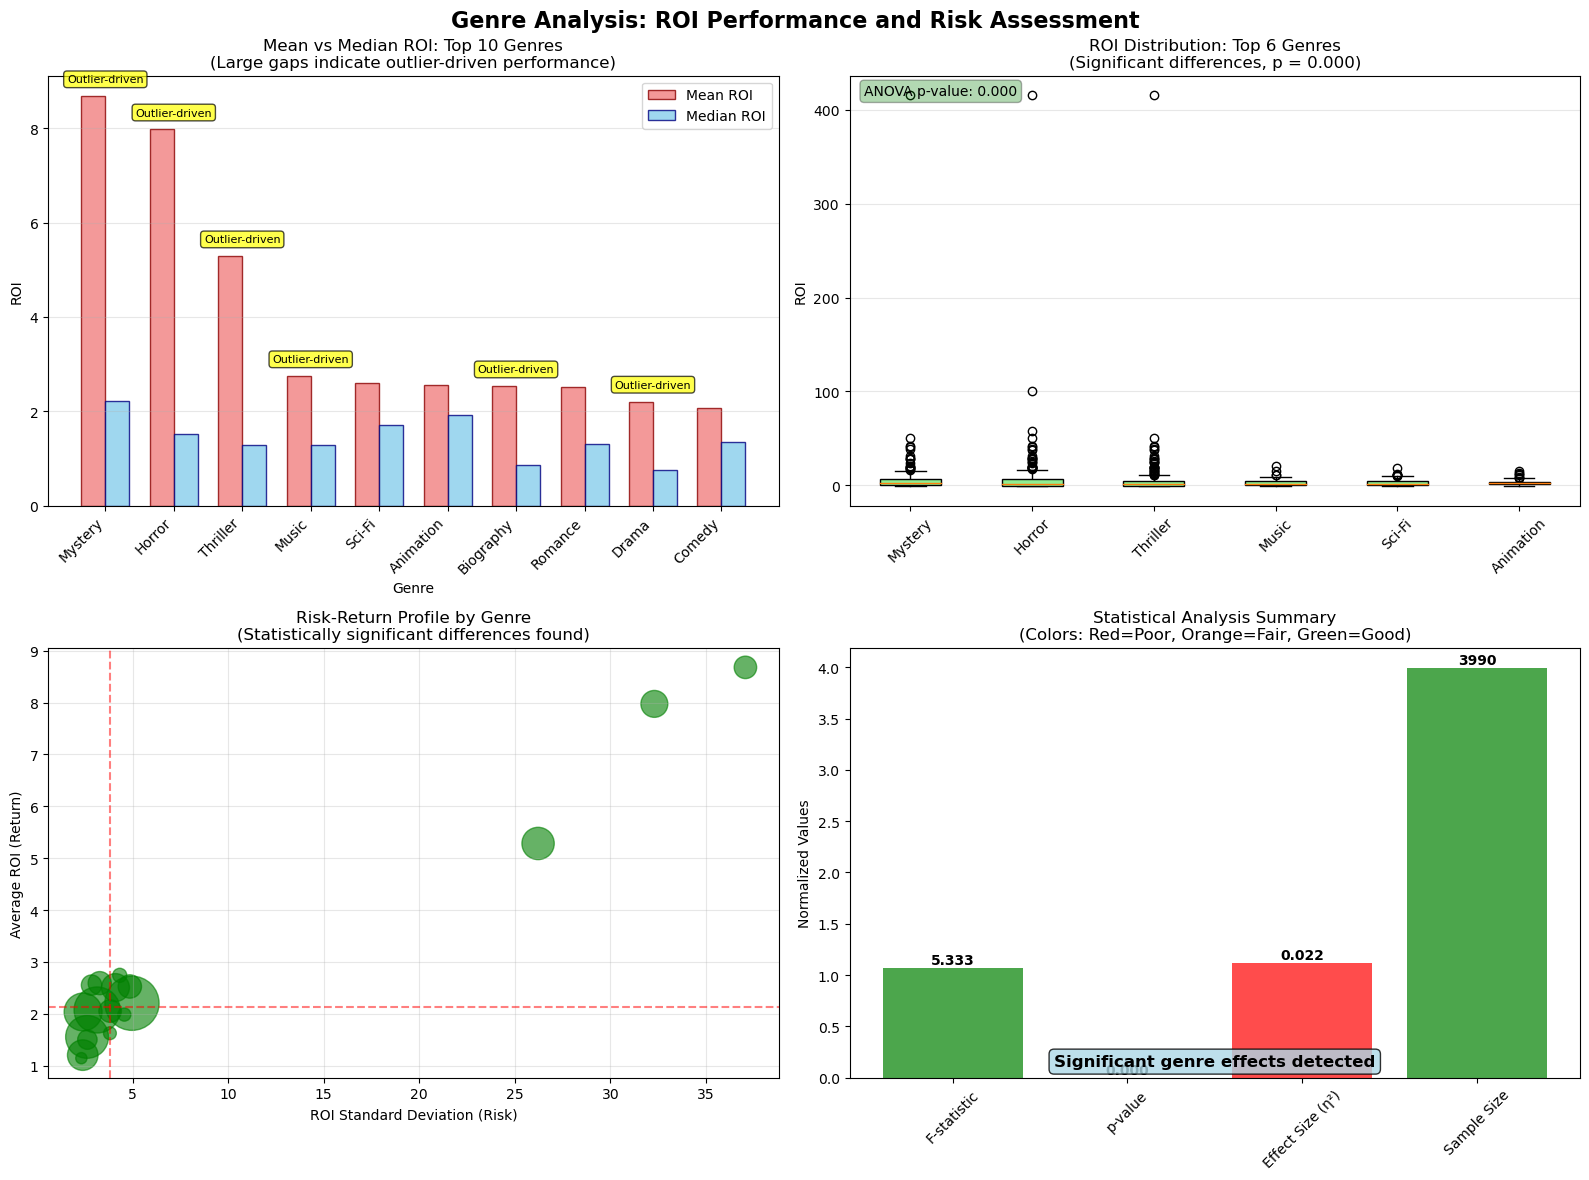

In [24]:
# VISUALIZATION CODE
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Genre Analysis: ROI Performance and Risk Assessment', fontsize=16, fontweight='bold')

# 1. Mean vs Median comparison (Updated primary chart)
ax1 = axes[0, 0]
top_10 = genre_stats_filtered.head(10)

# Create grouped bar chart for mean vs median
x = np.arange(len(top_10))
width = 0.35

bars1 = ax1.bar(x - width/2, top_10['ROI_mean'], width, label='Mean ROI', 
                color='lightcoral', alpha=0.8, edgecolor='darkred')
bars2 = ax1.bar(x + width/2, top_10['ROI_median'], width, label='Median ROI', 
                color='skyblue', alpha=0.8, edgecolor='navy')

ax1.set_xlabel('Genre')
ax1.set_ylabel('ROI')
ax1.set_title('Mean vs Median ROI: Top 10 Genres\n(Large gaps indicate outlier-driven performance)')
ax1.set_xticks(x)
ax1.set_xticklabels(top_10.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Highlight genres with high mean-median ratios
for i, (mean_val, median_val) in enumerate(zip(top_10['ROI_mean'], top_10['ROI_median'])):
    if pd.notna(median_val) and median_val != 0 and mean_val / median_val > 2.0:  # High skewness
        ax1.annotate('Outlier-driven', xy=(i, mean_val), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 2. Box plot comparison of top 6 genres
ax2 = axes[0, 1]
if len(top_genres) > 0:
    top_6_data = [df_genre[df_genre['genre'] == genre]['ROI'].values for genre in top_genres]
    box_plot = ax2.boxplot(top_6_data, labels=top_genres, patch_artist=True)

    # Color the boxes based on statistical significance
    colors = ['lightcoral' if pd.isna(p_value) or p_value >= 0.05 else 'lightgreen' for _ in box_plot['boxes']]
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)

    ax2.set_ylabel('ROI')
    title_text = 'ROI Distribution: Top 6 Genres'
    if pd.notna(p_value):
        if p_value >= 0.05:
            title_text += f'\n(No significant differences found, p = {p_value:.3f})'
        else:
            title_text += f'\n(Significant differences, p = {p_value:.3f})'
    ax2.set_title(title_text)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    # Add statistical result annotation
    if pd.notna(p_value):
        stat_color = 'red' if p_value >= 0.05 else 'green'
        ax2.text(0.02, 0.98, f'ANOVA p-value: {p_value:.3f}', transform=ax2.transAxes, 
                 va='top', ha='left', bbox=dict(boxstyle='round', facecolor=stat_color, alpha=0.3))

# 3. Risk-Return scatter with statistical context
ax3 = axes[1, 0]
# Color points based on whether differences are significant
if pd.notna(p_value):
    point_colors = ['red' if p_value >= 0.05 else 'green' for _ in range(len(genre_stats_filtered))]
else:
    point_colors = ['orange' for _ in range(len(genre_stats_filtered))]

scatter = ax3.scatter(genre_stats_filtered['ROI_std'], genre_stats_filtered['ROI_mean'],
                     s=genre_stats_filtered['ROI_count']*2, alpha=0.6, 
                     c=point_colors)
ax3.set_xlabel('ROI Standard Deviation (Risk)')
ax3.set_ylabel('Average ROI (Return)')

title_text = 'Risk-Return Profile by Genre'
if pd.notna(p_value):
    if p_value >= 0.05:
        title_text += '\n(No statistical support for genre-based strategies)'
    else:
        title_text += '\n(Statistically significant differences found)'
ax3.set_title(title_text)
ax3.grid(alpha=0.3)

# Add risk-return quadrant lines
ax3.axhline(y=genre_stats_filtered['ROI_mean'].median(), color='red', linestyle='--', alpha=0.5)
ax3.axvline(x=genre_stats_filtered['ROI_std'].median(), color='red', linestyle='--', alpha=0.5)

# 4. Statistical power and effect size visualization
ax4 = axes[1, 1]

if pd.notna(p_value) and pd.notna(f_statistic) and pd.notna(eta_squared):
    # Create a summary visualization of statistical findings
    metrics = ['F-statistic', 'p-value', 'Effect Size (η²)', 'Sample Size']
    values = [f_statistic, p_value, eta_squared, len(np.concatenate(genre_roi_data))]
    colors = ['green' if f_statistic > 2.0 else 'orange',
              'red' if p_value >= 0.05 else 'green',
              'red' if eta_squared < 0.06 else 'orange' if eta_squared < 0.14 else 'green',
              'green' if len(np.concatenate(genre_roi_data)) > 200 else 'orange']

    # Normalize values for visualization (different scales)
    norm_values = [f_statistic/5, p_value*10, eta_squared*50, len(np.concatenate(genre_roi_data))/1000]
    bars = ax4.bar(metrics, norm_values, color=colors, alpha=0.7)

    ax4.set_ylabel('Normalized Values')
    ax4.set_title('Statistical Analysis Summary\n(Colors: Red=Poor, Orange=Fair, Green=Good)')
    ax4.tick_params(axis='x', rotation=45)

    # Add actual values as text on bars
    for bar, value, metric in zip(bars, values, metrics):
        height = bar.get_height()
        if metric == 'Sample Size':
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{int(value)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add interpretation text
    interpretation = "No significant genre effects found" if p_value >= 0.05 else "Significant genre effects detected"
    ax4.text(0.5, 0.02, interpretation, transform=ax4.transAxes, ha='center', va='bottom',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             fontsize=12, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'Statistical analysis\nnot available', 
             transform=ax4.transAxes, ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

In [25]:
# ANOVA-BASED BUSINESS RECOMMENDATIONS
print("\n" + "="*70)
print("GENERATING BUSINESS RECOMMENDATIONS BASED ON ANOVA RESULTS")
print("="*70)

# Store ANOVA results for business recommendations
anova_results = {
    'f_statistic': f_statistic if pd.notna(f_statistic) else 0,
    'p_value': p_value if pd.notna(p_value) else 1.0,
    'eta_squared': eta_squared if pd.notna(eta_squared) else 0,
    'significant': p_value < 0.05 if pd.notna(p_value) else False,
    'effect_size': 'Large' if eta_squared > 0.14 else 'Medium' if eta_squared > 0.06 else 'Small' if pd.notna(eta_squared) else 'None'
}

# STATISTICAL FOUNDATION FOR BUSINESS DECISIONS
print(f"\nSTATISTICAL FOUNDATION:")
print(f"F-statistic: {anova_results['f_statistic']:.3f}")
print(f"p-value: {anova_results['p_value']:.6g}")
print(f"Effect size (η²): {anova_results['eta_squared']:.4f}")
print(f"Sample size: {len(df_genre):,} genre-movie combinations")
total_movies = len(df_genre)
covered_movies = genre_stats_filtered['ROI_count'].sum()
coverage_rate = covered_movies / total_movies * 100
print(f"Data Coverage: {coverage_rate:.1f}% ({covered_movies:,} of {total_movies:,} observations)")
print(f"Average Sample per Genre: {genre_stats_filtered['ROI_count'].mean():.1f} movies")

# BUSINESS RECOMMENDATION LOGIC
if anova_results['significant'] and anova_results['eta_squared'] >= 0.06:
    print(f"\n🟢 BUSINESS RECOMMENDATION: GENRE-FOCUSED STRATEGY")
    print(f"Statistical Evidence: p < 0.05 with {anova_results['effect_size'].lower()} effect size")
    
    print(f"\n📊 TOP INVESTMENT PRIORITIES:")
    top_genres_rec = genre_stats_filtered.head(5)
    for i, (genre, stats) in enumerate(top_genres_rec.iterrows(), 1):
        confidence = "HIGH" if stats['ROI_count'] >= 50 else "MEDIUM" if stats['ROI_count'] >= 30 else "MODERATE"
        print(f"{i}. {genre}:")
        print(f"   • Mean ROI: {stats['ROI_mean']:.2f} (Sample: {stats['ROI_count']} movies)")
        print(f"   • Confidence Level: {confidence}")
        print(f"   • Risk Level: {stats['risk_category']}")
    
    print(f"\n💰 RECOMMENDED BUDGET ALLOCATION:")
    print(f"• 50-60% budget → Top 3 genres with strongest statistical evidence")
    print(f"• 25-30% budget → Genres 4-6 for diversification")
    print(f"• 15-20% budget → Experimental/emerging genres")
    
    print(f"\n⚠️ GENRES TO APPROACH WITH CAUTION:")
    bottom_genres = genre_stats_filtered.tail(3)
    for genre, stats in bottom_genres.iterrows():
        print(f"• {genre}: Mean ROI {stats['ROI_mean']:.2f} (Risk: {stats['risk_category']})")
    
elif anova_results['significant'] and anova_results['eta_squared'] < 0.06:
    print(f"\n🟡 BUSINESS RECOMMENDATION: CAUTIOUS GENRE CONSIDERATION")
    print(f"Statistical Evidence: Significant differences but small effect size")
    
    print(f"\n📊 STRATEGY:")
    print(f"• Genre differences are real but small in practical terms")
    print(f"• Use genre as ONE factor among many in investment decisions")
    print(f"• Maintain diversified portfolio with slight bias toward top performers")
    print(f"• Focus more resources on script quality, casting, and production value")
    
    print(f"\n💰 RECOMMENDED APPROACH:")
    print(f"• Avoid dramatic shifts in genre focus")
    print(f"• Gradually increase investment in statistically proven genres")
    print(f"• Continue monitoring data as sample sizes grow")

else:
    print(f"\n🔴 BUSINESS RECOMMENDATION: DIVERSIFIED STRATEGY")
    print(f"Statistical Evidence: No reliable differences between genres (p ≥ 0.05)")
    
    print(f"\n📊 KEY INSIGHTS:")
    print(f"• Observed genre differences are likely due to random variation")
    print(f"• No statistical support for genre-based investment strategies")
    print(f"• Success factors lie beyond genre classification")
    
    print(f"\n💰 RECOMMENDED INVESTMENT APPROACH:")
    print(f"• Maintain balanced portfolio across ALL genres")
    print(f"• Focus investment decisions on proven success factors such as:")
    print(f"  - Budget optimization and cost management")
    print(f"  - Market research and audience testing")
    
    print(f"\n🔍 ALTERNATIVE ANALYSIS PRIORITIES:")
    print(f"• Analyze budget vs ROI relationships")
    print(f"• Study seasonal/quarterly release timing effects")
    print(f"• Investigate director/cast performance correlations")
    print(f"• Examine production company track records")

print(f"\nFINAL RECOMMENDATION SUMMARY:")
if anova_results['significant'] and anova_results['eta_squared'] >= 0.06:
    print(f"✅ INVEST STRATEGICALLY BY GENRE - Statistical evidence supports this approach")
else:
    print(f" - DO NOT use genre as a sole primary investment criterion - diversify your criterion to several factors")


GENERATING BUSINESS RECOMMENDATIONS BASED ON ANOVA RESULTS

STATISTICAL FOUNDATION:
F-statistic: 5.333
p-value: 6.58959e-12
Effect size (η²): 0.0223
Sample size: 4,030 genre-movie combinations
Data Coverage: 99.0% (3,990 of 4,030 observations)
Average Sample per Genre: 221.7 movies

🟡 BUSINESS RECOMMENDATION: CAUTIOUS GENRE CONSIDERATION
Statistical Evidence: Significant differences but small effect size

📊 STRATEGY:
• Genre differences are real but small in practical terms
• Use genre as ONE factor among many in investment decisions
• Maintain diversified portfolio with slight bias toward top performers
• Focus more resources on script quality, casting, and production value

💰 RECOMMENDED APPROACH:
• Avoid dramatic shifts in genre focus
• Gradually increase investment in statistically proven genres
• Continue monitoring data as sample sizes grow

FINAL RECOMMENDATION SUMMARY:
 - DO NOT use genre as a sole primary investment criterion - diversify your criterion to several factors


# PRODUCTION BUDGET VS ROI ANALYSIS
# Null Hypothesis: There is no relationship between a movie’s production budget and its ROI(Revenue earned)
# Alternate Hypothesis: There is a significant relationship between a movie's production budget and it's ROI

# 1. Visualizing the relationship between every movie's budget and its ROI

In [8]:
#importing the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

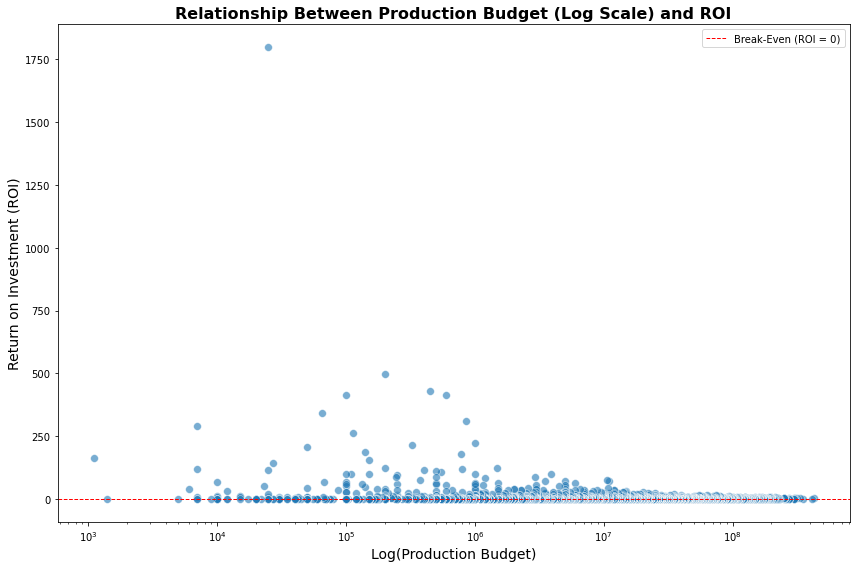

In [9]:
# Using a scatterplot
plt.figure(figsize=(12, 8))

# Create the scatter plot with log scale on x-axis
scatter_plot = sns.scatterplot(
    data=df_budget,
    x='production_budget',
    y='ROI',
    alpha=0.6,
    s=60
)

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add reference line
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Break-Even (ROI = 0)')

# Customize labels and title
plt.title('Relationship Between Production Budget (Log Scale) and ROI', fontsize=16, fontweight='bold')
plt.xlabel('Log(Production Budget)', fontsize=14)
plt.ylabel('Return on Investment (ROI)', fontsize=14)

# Remove the dollar formatting to show pure log values
# The log scale will automatically show values like 10^5, 10^6, 10^7, etc.

plt.legend()
plt.tight_layout()
plt.show()

## Interpretation of the scatter plot:
The graph shows the relationship between movie budgets and ROI(Return on Investment). Here are a few notable points:
1. The cloud of points slightly slopes downward from left to right. This visually confirms the initial hypothesis: as production budgets increase, the Return on Investment (ROI) tends to decrease. There are many low-budget movies with very high ROI and very few high-budget movies with very high ROI.

2. On the Left side(Low budget), the points are spread vertically across a massive range. This means low-budget movies are extremely unpredictable. They can result in massive losses (low points below the red line) or legendary, studio-making profits (points very high on the Y-axis).
    On the right side(High budget), the points are much more clustered together. Big-budget movies are less likely to have cataclysmic failures (though some do, points below the red line) but are also extremely unlikely to achieve the stratospheric ROI percentages of a breakout indie hit. Their outcomes are more predictable and clustered around a lower, often positive, ROI.

# 2. Calculating the corelation coefficient

In [11]:
# Import the stats module from scipy
from scipy import stats

# Calculate Pearson correlation and its p-value
# P-value will help us check if the correlation is statistically significant.
correlation, p_value = stats.pearsonr(df_budget['production_budget'], df_budget['ROI'])

print("Pearson Correlation Analysis:")
print(f"Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4e}") # Using scientific notation for very small p-values

# Interpret the p-value
if p_value < 0.05:
    print("--> The correlation is statistically significant (p < 0.05).")
else:
    print("--> The correlation is not statistically significant.")

Pearson Correlation Analysis:
Correlation Coefficient: -0.0487
P-value: 2.1085e-04
--> The correlation is statistically significant (p < 0.05).


## Interpretation of the correlation output:
Based on the Pearson correlation analysis, we found a statistically significant weak negative correlation between production budget and ROI (correlation coefficient = -0.0487, p-value < 0.05). This means that as production budgets increase, there is a slight tendency for ROI to decrease.

The negative correlation suggests that films with smaller budgets often achieve a higher return on investment percentage. This is because even a modest box office performance can result in a high ROI for a low-budget film, whereas high-budget films need to generate substantial revenue to achieve a similar ROI percentage.
While low-budget films can yield high ROIs, they also come with greater variability and risk. The scatter plot showed that low-budget films have a wide range of outcomes, from massive losses to extraordinary profits. High-budget films, on the other hand, tend to have more predictable but lower ROI outcomes.

# 3. Creating Budget tiers and Analyze group performance

In [13]:
# Create 4 budget tiers based on quartiles
df_budget['budget_tier'] = pd.qcut(
    df_budget['production_budget'],
    q=4, # Number of tiers (quartiles)
    labels=['Low', 'Medium', 'High', 'Very High'] # Labels for the tiers
)

# Calculate summary statistics for each tier
budget_tier_summary = df_budget.groupby('budget_tier')['ROI'].agg([
    ('mean_roi', 'mean'),
    ('median_roi', 'median'), # Median is often better than mean as it's robust to outliers
    ('movie_count', 'count'),
    ('std_dev', 'std') # Standard deviation to show risk/variability
]).round(2)

print("ROI Summary by Production Budget Tier:")
display(budget_tier_summary)

ROI Summary by Production Budget Tier:


,mean_roi,median_roi,movie_count,std_dev
budget_tier,,,,
Low,8.97,-0.04,1535,56.59
Medium,2.51,0.65,1382,6.08
High,1.62,0.66,1491,3.20
Very High,1.68,1.17,1374,2.21


In [14]:
df_budget.describe()

,year,quarter,production_budget,worldwide_gross,ROI,runtime_minutes
count,5782.000000,5782.000000,5.782000e+03,5.782000e+03,5782.000000,1582.000000
mean,2003.967139,2.662055,3.158776e+07,9.148746e+07,3.800161,106.458281
std,12.724386,1.125237,4.181208e+07,1.747200e+08,29.530282,20.863139
min,1915.000000,1.000000,1.100000e+03,0.000000e+00,-1.000000,-1.000000
25%,2000.000000,2.000000,5.000000e+06,4.125415e+06,-0.507704,94.000000
50%,2007.000000,3.000000,1.700000e+07,2.798445e+07,0.708310,105.000000
75%,2012.000000,4.000000,4.000000e+07,9.764584e+07,2.758346,118.000000
max,2020.000000,4.000000,4.250000e+08,2.776345e+09,1799.000000,180.000000


## Interpretation of the findings:
The mean ROI for the Low tier is massively inflated (8.97) by a few extreme outlier successes
Lower budget tiers are significantly riskier as shown by the std_dev. The outcomes are wildly unpredictable. As budgets increase, the possible outcomes become much more predictable and clustered around the median.
This analysis reveals a more nuanced strategy than initially expected. While low-budget films can achieve astronomical returns, they represent a high-risk gamble where the typical film loses money. For a new studio, a more sustainable path is to aim for the Medium to High budget range.

# 4. Visualizing the budget tiers

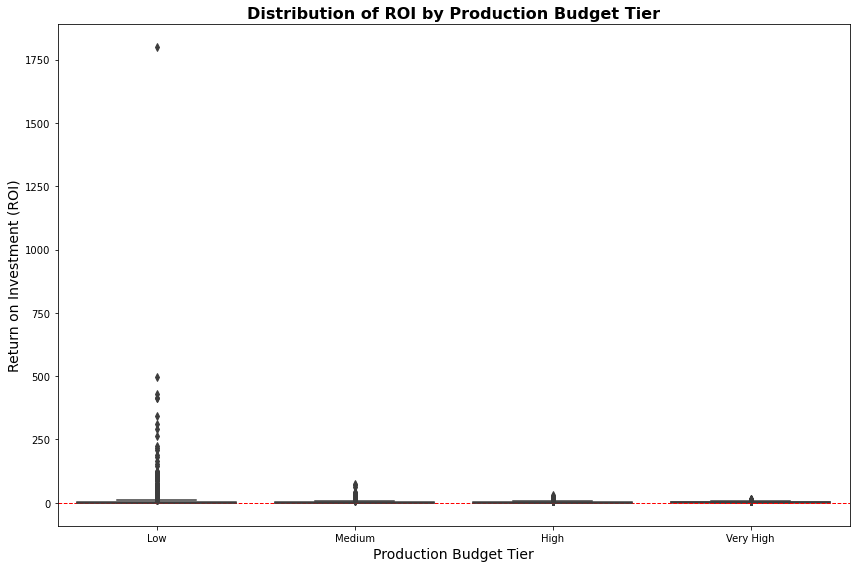

In [16]:
plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(
    data=df_budget,
    x='budget_tier',
    y='ROI',
    order=['Low', 'Medium', 'High', 'Very High'] # Ensure correct order
)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Distribution of ROI by Production Budget Tier', fontsize=16, fontweight='bold')
plt.xlabel('Production Budget Tier', fontsize=14)
plt.ylabel('Return on Investment (ROI)', fontsize=14)
plt.tight_layout()
plt.show()

## Interpretation of results:
1. For the Low Budget tier, the median ROI is below zero (approximately -0.04), meaning the typical low-budget movie loses money. The box is wide, and there are numerous outliers (both high and low), indicating extreme volatility and risk.

2. For the Medium Budget tier, the median ROI is positive (0.65), showing that the typical movie in this tier is profitable. The box is narrower than for low-budget films, but there are still some outliers, suggesting moderate risk.

3. For the High Budget tier, the median ROI is also positive (0.66) and similar to the medium tier, but the box is even narrower, indicating more consistent outcomes. The risk is lower than in lower tiers.

4. For the Very High Budget tiers, the median ROI is the highest (1.17), meaning the typical blockbuster more than doubles its investment. The box is the narrowest, with few outliers, showing that outcomes are predictable and less risky. This tier represents the "safest" bet for profitability, but it requires significant capital.

## RECOMMENDATIONS FOR THE BUSINESS

1. Prioritize Medium-Budget Films Initially: Focus your first productions in the medium-budget tier. This tier offers a strong and reliable median ROI of 0.65 (a 65% return), providing a stable foundation for the new studio without the extreme risk of lower budgets.

2. Graduate to High and Very High-Budget Films: As the studio establishes itself, shift resources toward higher-budget productions. The data shows these tiers offer the best combination of high median ROI (1.17 for Very High, meaning a 117% return) and low risk (standard deviation of 2.21), representing the most sustainable path to profitability.

3. Avoid a Low-Budget Strategy: Do not rely on low-budget films as a core strategy. While they can have high returns, the typical film in this tier loses money (median ROI of -0.04) and the outcomes are highly unpredictable (standard deviation of 56.59), making it an unacceptable risk for a new studio.

4. Implement a Phased Approach: Start by building a portfolio of medium-budget films to generate consistent returns. Use this stability to strategically fund a gradual expansion into the high and very high-budget tiers, which deliver superior and more predictable profits.

## Test whether the length of a movie (runtime) has an effect on its profitability (ROI) using Simple Linear Regression Model. 

- Independent Variable (X): Runtime (minutes)


- Dependent Variable (Y): ROI (Return on Investment) 


- Null Hypothesis (H₀): There is no relationship between movie runtime and ROI


- Alternative Hypothesis (H₁): There is a relationship between movie runtime and ROI

In [20]:
# Preparation - Create a join key using title + year

tn_clean["title_key"] = tn_clean["movie"].str.lower().str.strip() + tn_clean["year"].astype(str)
imdb["title_key"] = imdb["primary_title"].str.lower().str.strip() + imdb["start_year"].astype(str)

runtime_data = imdb.merge(tn_clean, on="title_key", how="inner")

print(runtime_data[["primary_title", "runtime_minutes", "ROI"]].head())

                     primary_title  runtime_minutes       ROI
0                       Foodfight!             91.0 -0.998362
1  The Secret Life of Walter Mitty            114.0  1.064409
2      A Walk Among the Tombstones            114.0  1.218164
3                   Jurassic World            124.0  6.669092
4                    The Rum Diary            119.0 -0.521228


In [21]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import statsmodels.api as sm

# Drop missing runtimes or ROIs
runtime_data = runtime_data.dropna(subset=["runtime_minutes", "ROI"])

# Define variables
X = runtime_data["runtime_minutes"]
y = runtime_data["ROI"]

# Add intercept
X = sm.add_constant(X)

# Fit regression
model = sm.OLS(y, X).fit()
print(model.summary())

# 95% CI for slope
print("95% CI for slope:", model.conf_int().loc["runtime_minutes"])


                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8405
Date:                Sun, 14 Sep 2025   Prob (F-statistic):              0.359
Time:                        21:59:06   Log-Likelihood:                -6081.8
No. Observations:                1564   AIC:                         1.217e+04
Df Residuals:                    1562   BIC:                         1.218e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.1866      1.703     

-The R² value (0.001) means runtime explains almost nothing about how profitable a movie is.

-The slope (-0.0144) and p-value (0.359) mean longer or shorter movies don’t significantly change profits.

-The confidence interval includes zero, which means the effect could be slightly positive or negative, but overall it’s too small to matter.

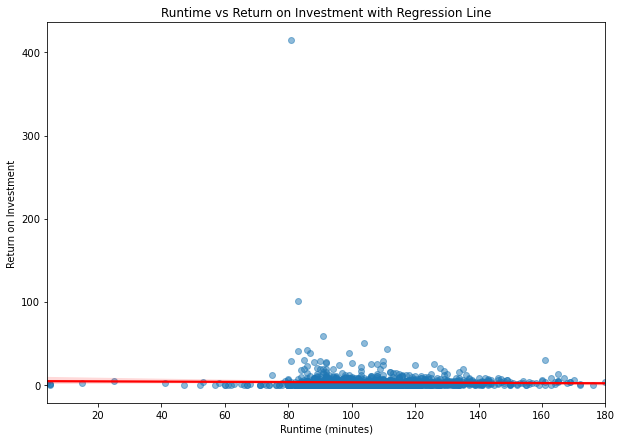

In [22]:
# Visualization
plt.figure(figsize=(10,7))
sns.regplot(x="runtime_minutes", y="ROI", data=runtime_data,
            scatter_kws={"alpha":0.5}, line_kws={"color":"red"})

plt.title("Runtime vs Return on Investment with Regression Line")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Return on Investment")
plt.show()

The visualization displayed above is a scatter plot of movie runtime vs ROI, with the regression line (in red) drawn across the data points. This makes it clear that the trend line is almost flat, confirming that runtime has no meaningful effect on profitability.

- Null Hypothesis (H₀): There is no relationship between movie runtime and ROI.

- Alternative Hypothesis (H₁):There is a relationship between movie runtime and ROI.

- Since the p-value = 0.359 > 0.05, we fail to reject H₀ → meaning runtime does not significantly impact profitability.

### Business Recommendation

The analysis shows that movie length does not significantly impact profitability, whether a film runs shorter or longer has almost no effect on its return on investment (ROI).

#### Implication for the Company:

Runtime should not be a deciding factor when selecting or producing films.Strategic focus should shift to more influential drivers of success such as:

 - Budget management (spending efficiently to maximize returns)

 - Release timing (launching films in profitable quarters/seasons)

 - Marketing and distribution strategies

Advice to Stakeholder: When developing original video content do not prioritize on movie length.
